<a href="https://colab.research.google.com/github/itsmuditt/Stock_Price_Prediction/blob/main/News_for_stock_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **WEB SCRAPING**

---
We will scrape headlines from websites using the piece of code in this segment.


---




In [ ]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

In [ ]:
import datetime
start_date = datetime.datetime(2010, 1, 1)

date_list = [start_date.date() + datetime.timedelta(days=x) for x in range(45219-40179)]
dates = [x.strftime("%d-%m-%Y") for x in date_list]


### **Economic Times Website's Archieves**

---


```
# Doing it for Economic Times website's ARCHIEVES
```



In [ ]:
news_et_val = []
for starttime in range(40179, 45219):
  url=f'https://economictimes.indiatimes.com/archivelist/starttime-{starttime}.cms'
  response = requests.get(url)

  soup = BeautifulSoup(response.text, 'html.parser')
  headlines = soup.body.find_all('td', class_="contentbox5")
  day = []
  for x in headlines:
    y = x.find_all('a')
    for heads in y:
      temp = heads.text.strip()
      if len(temp.split())>4:
        day.append([temp])

  news_et_val.append(day)

In [ ]:
news_et_df = pd.DataFrame(list(zip(dates, news_et_val)))

In [ ]:
news_et_df.to_csv('news_et_val.csv')

In [ ]:
len(news_et_df)

228

In [ ]:
news_et_df.columns


### **Times of India Website's Archieves**

---


```
# Doing it for Times of India website's ARCHIEVES
```



In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

import datetime
start_date = datetime.datetime(2010, 1, 1)

date_list = [start_date.date() + datetime.timedelta(days=x) for x in range(45219-40179)]
dates = [x.strftime("%d-%m-%Y") for x in date_list]

news_toi_val = []
base_url = "https://timesofindia.indiatimes.com"
# https://timesofindia.indiatimes.com/2023/2/24/archivelist/starttime-44981.cms
# https://timesofindia.indiatimes.com/archivelist/starttime-44981.cms
starttime = 40179
j = 0
for year in range(2010, 2024):
    for month in range(1, 13):
        for day in range(1, 32):
            # Check if the date is valid
            if month == 2 and day > 28:
                break
            elif month in [4, 6, 9, 11] and day > 30:
                break

            url = f"{base_url}/{year}/{month}/{day}/archivelist/year-{year},month-{month},starttime-{starttime}.cms"
            url1 = f"{base_url}/{year}/{month}/{day}/archivelist/starttime-{starttime}.cms"
            url2 = f"{base_url}/archivelist/starttime-{starttime}.cms"
            starttime += 1
            urls = [url, url1, url2]
            for url in urls:
                response = requests.get(url)
                soup = BeautifulSoup(response.text, 'html.parser')
                headlines = soup.body.find_all('span')

                day = []
                for x in headlines:
                    y = x.find_all('a')
                    for heads in y:
                        temp = heads.text.strip()
                        if len(temp.split())>4:
                            day.append([temp])
                if len(day) != 0:
                    break

            news_toi_val.append(day)
            print(j)
            j = j + 1
            if starttime == 45219:
                break
        if starttime == 45219:
            break
    if starttime == 45219:
        break


news_toi_df = pd.DataFrame(list(zip(dates, news_toi_val)))
news_toi_df.to_csv('news_toi_total.csv')


## **Revising our DATASET**

---

```
The dataset we were left with, after web scraping, had all the headlines into one column.

The below segment of code, changes it to having as many columns as the particular row requires.

```



---



In [ ]:
import pandas as pd
from numba import cuda
net = pd.read_csv('news_et_total.csv')
net = net.rename(columns={'1': 'Headlines'})
ntoi = pd.read_csv('news_toi_total.csv')
ntoi = ntoi.rename(columns={'1': 'Headlines'})

@cuda.jit
def split_sentences(row):
    max_sentences = len(row['Headlines'])
    cnt = 1
    i = 3
    while i < max_sentences:
        stri = '], ['
        tmp = row['Headlines'].find(stri, i)
        ans = 1e10
        if tmp == -1:
            tmp = 1e10
        ans = min(ans, tmp)
        if ans == 1e10:
            ans = max_sentences - 2
        j = ans-1

        hea = row['Headlines'][i:j]
        i = j + 6
        if hea == '[' or hea == ']':
            continue
        row[f'{cnt}'] = hea
        cnt = cnt + 1
        print(hea)
    return row

# Apply the function to split sentences
net = net.apply(split_sentences, axis=1)

# Drop the original 'Headlines' column
net.drop(columns=['Headlines'], inplace=True)

net = net.drop('Unnamed: 0', axis=1)

# Convert column names to integers and sort them numerically
net.columns = net.columns.astype(int)
net = net.reindex(sorted(net.columns), axis=1)

net.to_csv('et_rev_total.csv')



# Apply the function to split sentences
ntoi = ntoi.apply(split_sentences, axis=1)

# Drop the original 'Headlines' column
ntoi.drop(columns=['Headlines'], inplace=True)

ntoi = ntoi.drop('Unnamed: 0', axis=1)

# Convert column names to integers and sort them numerically
ntoi.columns = ntoi.columns.astype(int)
ntoi = ntoi.reindex(sorted(ntoi.columns), axis=1)

ntoi.to_csv('toi_rev_total.csv')


---
## Discarding irrelevant News Headlines
---

```
A NLP model has been created and uploaded to Hugging Face Hub.
Now we have to use that model and discard some of the news headlines based on their output categories.

This way, we will only be using the news that's relevant and affects the price of our Stock.

In broad terms, these categories that we have to save are:

> FINANCE
> BUSINESS
> POLITICS
> WORLD NEWS
> SCIENCE & TECHNOLOGY
> LIFESTYLE
> HEALTH & MEDICINE

Others, we will discard.

```


In [ ]:
# Installing Transformers with sentencepiece
!pip install --no-cache-dir transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 196.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 147.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 212.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 222.7 MB/s eta 0:00:00



```
'HEALTH & MEDICINE': 0
'ENTERTAINMENT': 1
'FINANCE': 2
'SCIENCE & TECHNOLOGY': 3
'WORLD NEWS': 4
'EDUCATION': 5
'SOCIETY': 6
'POLITICS': 7
'ENVIRONMENT': 8
'BUSINESS': 9
'MEDIA': 10
'FOOD': 11
'CRIME': 12
'LIFESTYLE': 13
'SPORTS': 14
```

In [ ]:
from transformers import TFDistilBertForSequenceClassification
from sklearn.metrics import f1_score
from tqdm import tqdm
import pickle
from transformers import BertTokenizer, BertForSequenceClassification
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
from tqdm import trange

from transformers import pipeline
import pandas as pd

In [ ]:
# Use a pipeline as a high-level helper
classifier = pipeline("text-classification", model="Yueh-Huan/news-category-classification-distilbert")

In [ ]:
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)

# News_Category_Dataset_v3.json is the dataset on which this transformer model was trained on

In [ ]:
df.columns

Index(['link', 'headline', 'category', 'short_description', 'authors', 'date'], dtype='object')

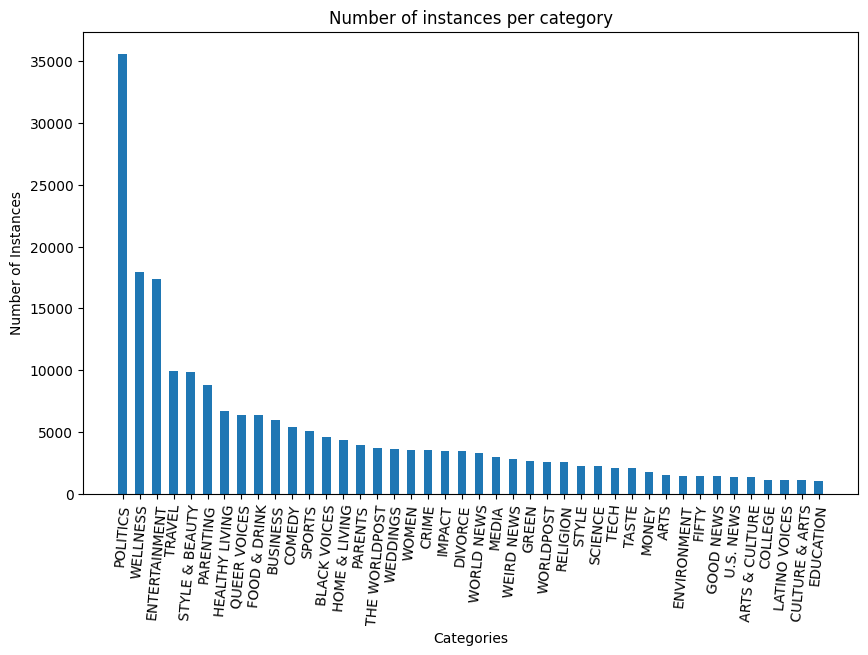

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# assuming df is your DataFrame and 'label' is your column with categories
counts = df['category'].value_counts()

plt.figure(figsize=(10,6))  # Set the figure size
plt.bar(counts.index, counts.values, width=0.5)  # Create the bar chart

plt.title('Number of instances per category')  # Set the title
plt.xlabel('Categories')  # Set x-axis label
plt.ylabel('Number of Instances')  # Set y-axis label
plt.xticks(rotation=85)  # Rotate x-axis labels for better visibility

plt.show()

In [ ]:
unique_values = df['category'].unique()
for uni in unique_values:
    print(uni, sep= ' ')

U.S. NEWS
COMEDY
PARENTING
WORLD NEWS
CULTURE & ARTS
TECH
SPORTS
ENTERTAINMENT
POLITICS
WEIRD NEWS
ENVIRONMENT
EDUCATION
CRIME
SCIENCE
WELLNESS
BUSINESS
STYLE & BEAUTY
FOOD & DRINK
MEDIA
QUEER VOICES
HOME & LIVING
WOMEN
BLACK VOICES
TRAVEL
MONEY
RELIGION
LATINO VOICES
IMPACT
WEDDINGS
COLLEGE
PARENTS
ARTS & CULTURE
STYLE
GREEN
TASTE
HEALTHY LIVING
THE WORLDPOST
GOOD NEWS
WORLDPOST
FIFTY
ARTS
DIVORCE


In [ ]:
from numba import jit, cuda
from transformers import pipeline
import pandas as pd

list_save = ['MONEY', 'BUSINESS', 'POLITICS', 'WORLDPOST', 'U.S. NEWS', 'SCIENCE', 'TECH', 'MEDIA', 'THE WORLDPOST', 'WORLD NEWS', 'IMPACT']

@jit(target_backend='cuda')
def classify(net_rev, ntoi_rev, classifier):
    save_tet = []
    for i in range(len(net_rev)):
        dayz_save = []
        for col in range(1, len(net_rev.columns)-1):
            head = net_rev[f'{col}'][i]
            if(pd.isnull(head)):
                break
            op = classifier(head)[0]['label']
            print(op)
            if op in list_save:
                dayz_save.append([op])
        save_tet.append(dayz_save)
    saved_et = pd.DataFrame(save_tet)
    saved_et.to_csv('saved_et_total.csv')

    save_ttoi = []
    for i in range(len(ntoi_rev)):
        dayz_save = []
        for col in range(1, len(ntoi_rev.columns)-1):
            head = ntoi_rev[f'{col}'][i]
            if(pd.isnull(head)):
                break
            op = classifier(head)[0]['label']
            print(op)
            if op in list_save:
                dayz_save.append([op])
        save_ttoi.append(dayz_save)
    saved_toi = pd.DataFrame(save_ttoi)
    saved_toi.to_csv('saved_toi_total.csv')

    return "Both Datasets have been classified!"

if  __name__ == "__main__":
    classifier = pipeline("text-classification", model="Yueh-Huan/news-category-classification-distilbert", device=0)
    net_rev = pd.read_csv('et_rev_total.csv', index_col=False)
    ntoi_rev = pd.read_csv('toi_rev_total.csv', index_col=False)
    print(classify(net_rev, ntoi_rev, classifier))

```
Now we have two refined datasets, saved_et.csv and saved_toi.csv, which have news headlines that wew can ultimately use with any stock price.

Now, only the labels will change according to the name of stock.

Headlines will be the same!
```

---
##Merging the two datasets
---

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
saved_et = pd.read_csv('/content/drive/MyDrive/Dataset/Stock Price Prediction/News/saved_et_total.csv', index_col=False)
saved_toi = pd.read_csv('/content/drive/MyDrive/Dataset/Stock Price Prediction/News/saved_toi_total.csv', index_col=False)

<ipython-input-11-accbd854ec04>:1: DtypeWarning: Columns (407,408,409,410,411,412,413,414,415,416,417,418,419,420) have mixed types. Specify dtype option on import or set low_memory=False.
  saved_et = pd.read_csv('/content/drive/MyDrive/Dataset/Stock Price Prediction/News/saved_et_total.csv', index_col=False)


In [ ]:
len(saved_et)

5040

In [ ]:
saved_et.head(2)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,410,411,412,413,414,415,416,417,418,419
0,0,['Companies adopt wierd names to catch consume...,['Bharti bags Bangladesh’s Warid for bargain p...,['Shree Cement acquires 90 acres for new proje...,['DoT plans country-wide MNP launch by March 31'],['Pranab Mukherjee plans more cash flow for fa...,"['Fannie, Freddie proving too big to shrink']",['I-T dept hits upon bogus investment losses'],['India may ask US to ease trade curbs in fres...,['General insurers to set up Motor Insurance B...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"['Commexes on a high, but some futures woes re...",['Indian companies buy land abroad for agricul...,"['IT, cement and steel to drive India’s growth']",['Russia sets minimum price for vodka'],"['Cos get realistic, switch to Apr-Mar account...","['Cos get realistic, switch to Apr-Mar account...","['Suicide attack kills 89, injures 83 in Pak o...",['CLB asks Nilgiris Dairy Farm to hold allotme...,"[""UK 'not sharing' Pak intel despite pact with...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Merge DataFrames on 'Date'
saved_merged = saved_et.merge(saved_toi, on='Unnamed: 0', how='outer')

In [ ]:
# Reorder columns so that NaNs are at the end
df_resultant = saved_merged.apply(lambda row: sorted(row, key=pd.isnull), axis=1)


In [ ]:
saved_merged.head(1)

,Unnamed: 0,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,320_y,321_y,322_y,323_y,324_y,325_y,326_y,327_y,328_y,329_y
0,0,['Companies adopt wierd names to catch consume...,['Bharti bags Bangladesh’s Warid for bargain p...,['Shree Cement acquires 90 acres for new proje...,['DoT plans country-wide MNP launch by March 31'],['Pranab Mukherjee plans more cash flow for fa...,"['Fannie, Freddie proving too big to shrink']",['I-T dept hits upon bogus investment losses'],['India may ask US to ease trade curbs in fres...,['General insurers to set up Motor Insurance B...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_resultant.to_csv('res_total.csv')

###Revising this final Dataset

In [ ]:
res = pd.read_csv('res_total.csv')

In [ ]:
def split_sentences(row):
    max_sentences = len(row['0'])
    cnt = 1
    i = 7
    while i < max_sentences:
        stri = ['\']', '"]']
        tmp = [row['0'].find(stri[0], i), row['0'].find(stri[1], i)]
        ans = 1e10
        for t in tmp:
            if t == -1:
                t = 1e10
            ans = min(ans, t)
        if ans == 1e10:
            break
        j = ans

        head = row['0'][i:j]
        i = j + 8
        if head == '[' or head == ']':
            continue
        row[f'{cnt}'] = head
        cnt = cnt + 1
        print(head)
    return row

In [ ]:
# Apply the function to split sentences
res = res.apply(split_sentences, axis=1)

In [ ]:
# Drop the original 'Headlines' column
res.drop(columns=['0'], inplace=True)

In [ ]:
res.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
# Convert column names to integers and sort them numerically
res.columns = res.columns.astype(int)
res = res.reindex(sorted(res.columns), axis=1)

In [ ]:
res.to_csv('res_rev.csv')

In [ ]:
res_rev = pd.read_csv('res_rev.csv')

<ipython-input-31-da8451ceb444>:1: DtypeWarning: Columns (494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709) have mixed types. Specify dtype option on import or set low_memory=False.
  r

In [ ]:
res_rev.replace({'â': "'", 'â': "'"}, regex=True, inplace=True)

In [ ]:
res_new = res_rev.replace(to_replace=r"\\", value="", regex=True)

In [ ]:
res_new.to_csv('res_rev.csv')

In [ ]:
# Define a function to drop characters from the string based on the index
def drop_chars(cell, index):
    if index >= 10 and index < 100:
        return cell[1:]
    elif index >= 100 and index < 1000:
        return cell[2:]
    elif index >= 1000:
        return cell[3:]
    else:
        return cell


In [ ]:
    # Apply the function to each cell of the 'col_1' column
res_new['1'] = [drop_chars(cell, idx) for idx, cell in enumerate(res_new['1'])]

In [ ]:
# Access a particular cell
cell_value = res_new.loc[8, '4']


In [ ]:
# Find out the data type of the cell
cell_dtype = type(cell_value)

In [ ]:
res_new.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
res_new.tail(3)

,1,2,3,4,5,6,7,8,9,10,...,700,701,702,703,704,705,706,707,708,709
5037,"DoT decides to auction all unsold airwaves, again",Delhi excise policy case: When will arguments ...,SC notice to DK Shivakumar on CBI plea challen...,India is the shining star of Asia now: Tyler D...,India is the shining star of Asia now: Tyler D...,Congress names all 40 candidates for Mizoram,Chinese brands follow Samsung into flip phone ...,"SP releases list of nine candidates in MP, lea...","SP releases list of nine candidates in MP, lea...",US tackles loopholes in curbs on AI chip expor...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5038,Oil prices gain ahead of Biden's visit to Israel,Four or five days of food left in Gaza shops: WFP,RBI may opt to roll over $5-b forex swap,RBI may opt to roll over $5 billion forex swap,UK regular pay growth slows for first time sin...,Mopup of savings scheme for elderly crosses Rs...,Offer to Central Asia: Fully-funded skill prog...,"Qualcomm, Google partner to make RISC-V chip f...",Maritime sector sets sights on Rs 80 lakh cr i...,"BJP, RSS hail verdict; Congress 'studying diff...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5039,"Won't enter legislative domain, says SC",JM Baxi Group promoter moves HC over stake buy...,Left wing extremism against development: Amit ...,Russian Duma passes law to revoke ratification...,Rising concerns over delayed arrival of kharif...,UNSC fails to adopt resolution on Israel-Pales...,Festive demand sends wheat prices higher; outp...,NCLT admits insolvency plea against Supertech ORB,"Curbs extended on exports of sugar, eased for ...",AWS previews customisation ability of coding a...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
res_new.index.name = 'Index'

In [ ]:
res_new.head(3)

,1,2,3,4,5,6,7,8,9,10,...,700,701,702,703,704,705,706,707,708,709
Index,,,,,,,,,,,,,,,,,,,,,
0,Companies adopt wierd names to catch consumer ...,Bharti bags Bangladesh’s Warid for bargain pri...,Shree Cement acquires 90 acres for new projects,DoT plans country-wide MNP launch by March 31,Pranab Mukherjee plans more cash flow for farm...,"Fannie, Freddie proving too big to shrink",I-T dept hits upon bogus investment losses,India may ask US to ease trade curbs in fresh ...,General insurers to set up Motor Insurance Bureau,BSNL may have to shelve $1-bn IT outsourcing deal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Commexes on a high, but some futures woes remain",Indian companies buy land abroad for agricultu...,"IT, cement and steel to drive India’s growth",Russia sets minimum price for vodka,"Cos get realistic, switch to Apr-Mar accountin...","Cos get realistic, switch to Apr-Mar accountin...","Suicide attack kills 89, injures 83 in Pak on ...",CLB asks Nilgiris Dairy Farm to hold allotment...,UK 'not sharing' Pak intel despite pact with I...,'Growth & profitability slow consolidation in ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Analyst's Pick: SMALL CAP: ICICI Securities,Analyst's Pick: LARGE CAP: Anand Rathi Financi...,Analyst's Pick: LARGE CAP: Anand Rathi Financi...,Top steel companies increase prices,'Google phone' debut expected this week,Eurozone faces 2010 debt crisis,Things to remember while availing tax breaks,Rs 18 crore splurged on House panels,New job avenue for aam admi,Delhi comes third in terms of tree cover,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
res_new.to_csv('/content/drive/MyDrive/Dataset/Stock Price Prediction/News/res_new_without_date.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Stock Price Prediction/News/res_new_without_date.csv')

<ipython-input-188-42ff05c9ff64>:1: DtypeWarning: Columns (637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Dataset/Stock Price Prediction/News/res_new_without_date.csv')


In [ ]:
import datetime
start_date = datetime.datetime(2010, 1, 1)

date_list = [start_date.date() + datetime.timedelta(days=x) for x in range(45219-40179)]
dates = [x.strftime("%d-%m-%Y") for x in date_list]

In [ ]:
len(dates)

5040

In [ ]:
res_new.head(2)

,1,2,3,4,5,6,7,8,9,10,...,700,701,702,703,704,705,706,707,708,709
Index,,,,,,,,,,,,,,,,,,,,,
0,Companies adopt wierd names to catch consumer ...,Bharti bags Bangladesh’s Warid for bargain pri...,Shree Cement acquires 90 acres for new projects,DoT plans country-wide MNP launch by March 31,Pranab Mukherjee plans more cash flow for farm...,"Fannie, Freddie proving too big to shrink",I-T dept hits upon bogus investment losses,India may ask US to ease trade curbs in fresh ...,General insurers to set up Motor Insurance Bureau,BSNL may have to shelve $1-bn IT outsourcing deal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Commexes on a high, but some futures woes remain",Indian companies buy land abroad for agricultu...,"IT, cement and steel to drive India’s growth",Russia sets minimum price for vodka,"Cos get realistic, switch to Apr-Mar accountin...","Cos get realistic, switch to Apr-Mar accountin...","Suicide attack kills 89, injures 83 in Pak on ...",CLB asks Nilgiris Dairy Farm to hold allotment...,UK 'not sharing' Pak intel despite pact with I...,'Growth & profitability slow consolidation in ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Replace the 'Unnamed: 0' column with the new list
res_new.insert(loc=0, column='Date', value=dates)

<ipython-input-46-097f130267d8>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res_new.insert(loc=0, column='Date', value=dates)


In [ ]:
res_new.head(1)

,Date,1,2,3,4,5,6,7,8,9,...,700,701,702,703,704,705,706,707,708,709
Index,,,,,,,,,,,,,,,,,,,,,
0,01-01-2010,Companies adopt wierd names to catch consumer ...,Bharti bags Bangladesh’s Warid for bargain pri...,Shree Cement acquires 90 acres for new projects,DoT plans country-wide MNP launch by March 31,Pranab Mukherjee plans more cash flow for farm...,"Fannie, Freddie proving too big to shrink",I-T dept hits upon bogus investment losses,India may ask US to ease trade curbs in fresh ...,General insurers to set up Motor Insurance Bureau,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
res_new.to_csv('news_dataset_for_financial_analysis_v2.csv')



```
Dates added!
Datasets merged.
CSV Saved!
```



## Adding Sentiment Score

In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline
pipe = pipeline("text-classification",
                model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
                device=0)

In [ ]:
import pandas as pd
df = pd.read_csv('news_dataset_for_financial_analysis_v2.csv', index_col=False)

<ipython-input-21-f409397c2343>:2: DtypeWarning: Columns (495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710) have mixed types. Specify dtype option on import or set low_memory=False.
  d

In [ ]:
df.head(2)

,Index,Date,1,2,3,4,5,6,7,8,...,700,701,702,703,704,705,706,707,708,709
0,0,01-01-2010,Companies adopt wierd names to catch consumer ...,Bharti bags Bangladesh’s Warid for bargain pri...,Shree Cement acquires 90 acres for new projects,DoT plans country-wide MNP launch by March 31,Pranab Mukherjee plans more cash flow for farm...,"Fannie, Freddie proving too big to shrink",I-T dept hits upon bogus investment losses,India may ask US to ease trade curbs in fresh ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,02-01-2010,"Commexes on a high, but some futures woes remain",Indian companies buy land abroad for agricultu...,"IT, cement and steel to drive India’s growth",Russia sets minimum price for vodka,"Cos get realistic, switch to Apr-Mar accountin...","Cos get realistic, switch to Apr-Mar accountin...","Suicide attack kills 89, injures 83 in Pak on ...",CLB asks Nilgiris Dairy Farm to hold allotment...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(5040, 711)

In [ ]:
df[df['Index'] == 0]

In [ ]:
def scale_value(value):
    min_val = 0
    max_val = 1
    new_min = -0.2
    new_max = 0.2
    scaled_value = ((value - min_val) / (max_val - min_val))
    scaled_value = scaled_value * (new_max - new_min)
    scaled_value = scaled_value  + new_min
    return scaled_value

In [ ]:
def give_score(row):
  score = 0.0
  cnt = 0
  cols = 710
  for i in range(1, cols):
    head = row[f'{i}']
    if pd.isna(head):
      break
    cnt = cnt + 1
    op = pipe(head)
    if op[0]['label'] == 'negative':
      score = score - op[0]['score']
    elif op[0]['label'] == 'neutral':
      score = score + scale_value(op[0]['score'])
    else:
      score = score + op[0]['score']
  avg = score/cnt
  print(avg, "---", cnt)
  return avg, cnt

In [ ]:
# Apply the function to each row
score_df = df[df.columns.difference(['Date'])].apply(give_score, axis=1, result_type='expand')
score_ = score_df.assign(Date = df['Date'])

In [ ]:
score = score_.rename(columns={'0':'financial_score', '1':'count'})
score.to_csv('financial_scores.csv')

---
---

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

---
---